# 과제
## 실전 문제 해결 (부족한 데이터셋)

In [1]:
# !pip install -U imbalanced-learn

In [20]:
import tensorflow as tf
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
import random

## 하이퍼 파라미터

In [21]:
EPOCHS = 100

## 모델정의

In [22]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x, training=False, mask=None):
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

## 데이터셋 준비(불균형한 데이터셋)

In [39]:
cifar10 = tf.keras.datasets.cifar10 # 32x32x3

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# TODO: 학습 데이터를 Imbalanced small dataset으로 변형하기
x_train_small = list()
y_train_small = list()
for x, y in zip(x_train, y_train):
    if (y == 0 and random.randint(0, 100) < 10) or y == 1:
        x_train_small.append(x[:])
        y_train_small.append(y)

x_test_small = list()
y_test_small = list()
for x, y in zip(x_test, y_test):
    if y == 0 or y == 1:
        x_test_small.append(x[:])
        y_test_small.append(y)

x_train = np.stack(x_train_small, axis=0)
y_train = np.stack(y_train_small, axis=0)

x_test = np.stack(x_test_small, axis=0)
y_test = np.stack(y_test_small, axis=0)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32).prefetch(2048)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(2048)

In [40]:
np.stack(y_train_small, axis=0)


array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]], dtype=uint8)

In [41]:
unique, counts = np.unique(y_train, return_counts=True)

unique_yt = dict(zip(unique, counts))
unique_yt

{0: 469, 1: 5000}

In [42]:
unique, counts = np.unique(y_test, return_counts=True)

unique_yt = dict(zip(unique, counts))
unique_yt

{0: 1000, 1: 1000}

--x값--


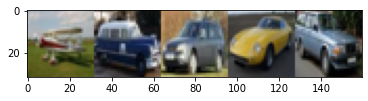

--y value--
[[0]
 [1]
 [1]
 [1]
 [1]]


In [43]:
# 5개의 이미지를 수평으로 나란히 출력
import matplotlib.pyplot as plt
print('--x값--')
plt.imshow(np.hstack(x_train[25:30]))
plt.show()

print('--y value--')
print(y_train[25:30])

## 차인지 아닌지 구분하는 데이터셋

## Keras API 모델 학습 (불균형한 데이터셋)

In [44]:
model = MyModel()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
history = model.fit_generator(train_ds, validation_data=test_ds, epochs=EPOCHS)

Epoch 1/100
171/171 [==============================] - 2s 8ms/step - loss: 0.3865 - accuracy: 0.9148 - precision: 0.9155 - recall: 0.9990 - val_loss: 0.7062 - val_accuracy: 0.5880 - val_precision: 0.5489 - val_recall: 0.9880
Epoch 2/100
171/171 [==============================] - 1s 7ms/step - loss: 0.2430 - accuracy: 0.9206 - precision: 0.9247 - recall: 0.9942 - val_loss: 0.7877 - val_accuracy: 0.6205 - val_precision: 0.5695 - val_recall: 0.9870
Epoch 3/100
171/171 [==============================] - 1s 6ms/step - loss: 0.2269 - accuracy: 0.9210 - precision: 0.9308 - recall: 0.9870 - val_loss: 0.5285 - val_accuracy: 0.7755 - val_precision: 0.7048 - val_recall: 0.9480
Epoch 4/100
171/171 [==============================] - 1s 6ms/step - loss: 0.2091 - accuracy: 0.9283 - precision: 0.9384 - recall: 0.9864 - val_loss: 0.5284 - val_accuracy: 0.7705 - val_precision: 0.6979 - val_recall: 0.9540
Epoch 5/100
171/171 [==============================] - 1s 7ms/step - loss: 0.2088 - accuracy: 0.9285

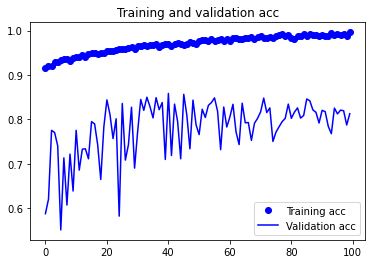

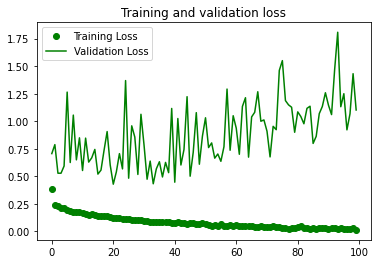

In [45]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

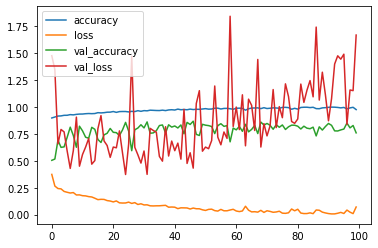

In [12]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend(loc = "upper left")
plt.show()

## 데이터셋 준비 (BorderlineSMOTE)

In [13]:
# TODO: BorderlineSMOTE 적용하기
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])).astype(np.float32)

smote = BorderlineSMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32).prefetch(2048)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(2048)

In [14]:
unique, counts = np.unique(y_train, return_counts=True)

unique_yt = dict(zip(unique, counts))
unique_yt

{0: 5000, 1: 5000}

In [15]:
unique, counts = np.unique(y_test, return_counts=True)

unique_yt = dict(zip(unique, counts))
unique_yt

{0: 1000, 1: 1000}

In [16]:
len(x_train[0])

3072

## Keras API 모델 학습 (BorderlineSMOTE)

In [17]:
model = MyModel()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
history = model.fit_generator(train_ds, validation_data=test_ds, epochs=EPOCHS)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
313/313 [==============================] - 3s 7ms/step - loss: 0.5343 - accuracy: 0.7658 - precision: 0.7813 - recall: 0.7382 - val_loss: 0.5855 - val_accuracy: 0.7365 - val_precision: 0.6693 - val_recall: 0.9350
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 0.3940 - accuracy: 0.8281 - precision: 0.8450 - recall: 0.8036 - val_loss: 0.4142 - val_accuracy: 0.8145 - val_precision: 0.8670 - val_recall: 0.7430
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 0.2980 - accuracy: 0.8807 - precision: 0.9053 - recall: 0.8504 - val_loss: 0.5783 - val_accuracy: 0.7625 - val_precision: 0.6929 - val_recall: 0.9430
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 0.2433 - accuracy: 0.9053 - precision: 0.9264 - recall: 0.8806 - val_loss: 0.9063 - val_accuracy: 0.6465 - val_precision: 0.5870 - val_recall: 0.9880
Epoch 5/100
313/313 [==============================] - 2s 6ms/step - loss: 0.2029 - accuracy: 0.9273

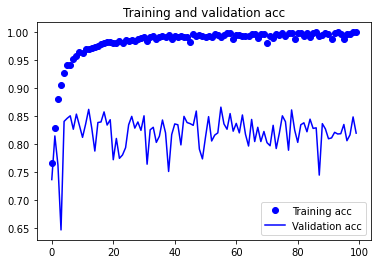

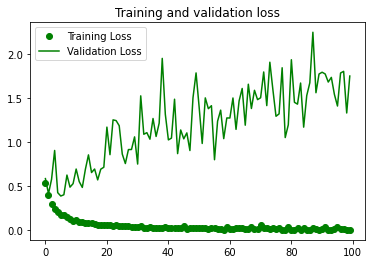

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

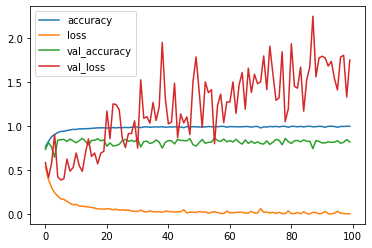

In [19]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend(loc = "upper left")
plt.show()